Libraries

In [34]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

Network Architecture

In [35]:
activation_map = {

    'tanh' : nn.Tanh(),
    'relu' :  nn.ReLU(),
    'sigmoid' : nn.Sigmoid(),
    'none' : None,
    'None': None

}


class PINNet(nn.Module):
    def __init__(self, layers, activation):
        super().__init__()
        if len(activation)==len(layers):
            layer_list=[]
            activation_model= [activation_map[act] for act in activation]
            for i in range(1, len(activation)):
                layer_list.append(nn.Linear(layers[i-1], layers[i]))
                if activation_model[i] is not None:
                    layer_list.append(activation_model[i])

            self.network = nn.Sequential(*layer_list)

    def forward(self,*args):
        out = torch.cat(args, dim=1)
        return self.network(out)

Optimizer Functions

In [36]:
def optimizer(opt, parameters, lr):

    optima= getattr(torch.optim, opt)
    optimize = optima(parameters, lr=lr)

    return optimize

Xavier Weight Initialization

In [37]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

Gradient Functions

In [38]:
def grad(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def hessian(y, x):
    z = grad(y, x)
    return torch.autograd.grad(z, x, grad_outputs=torch.ones_like(z), create_graph=True)[0]

Diffusivity (piecewise)

In [39]:
alpha1 = 4.7e-7     # layer 1 (0-0.35m)
alpha2 = 6.3e-7     # layer 2 (0.35-0.7m)
alpha3 = 8.2e-7     # layer 3 (0.7- 1m)

def diffusivity(z):
    s1 = z/0.35
    s2 =(z-0.35)/0.35
    g1 = 3*s1**2 -2*s1**3
    g2 = 3*s2**2 -2*s2**3
    return torch.where(z < 0.35,
                       alpha1 + (alpha2-alpha1)*g1,
                       torch.where(z < 0.7, alpha2 + (alpha3-alpha2)*g2, alpha3))
    

def heat_source(x, t):
    area = 2 # m2
    depth =  0.06 # m
    t_cap = 1800*800*area*depth
    period = 24   #/72
    t_hours =t*72
    sine_wave = torch.sin(2*np.pi * t_hours/period)
    Q1 = 30* (1+sine_wave)/(2*t_cap) 
    #Q2 = 20* (1+sine_wave)/(2*t_cap)
    #Q3 = 10* (1+sine_wave)/(2*t_cap) 
    
    Q_layer = torch.where((x>=0.82)&(x<0.88), Q1*torch.ones_like(x), torch.zeros_like(x))  
    '''Q_on = torch.where(
        t <= (8/72), Q1*torch.ones_like(t), 
        torch.where(
            (t>24/72)&(t<32/72), Q2*torch.ones_like(t), 
            torch.where(
                (t>48/72)&(t<56/72), Q3*torch.ones_like(t), 
                torch.zeros_like(t)
            )
        )
    )'''
    return Q_layer #*Q_on

Input

In [40]:
z_min, z_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0
T0 = 18.0  # initial temp

N_f = 10000
z_f = torch.rand((N_f,1))
t_f = torch.rand((N_f,1))

N_ic = 200
z_ic = torch.rand((N_ic,1))
t_ic = torch.zeros_like(z_ic)
T_ic = torch.ones_like(z_ic) * T0

N_bc = 200
z_bc_top = torch.zeros((N_bc//2,1))
t_bc_top = torch.rand((N_bc//2,1))

z_bc_bot = torch.ones((N_bc//2,1))
t_bc_bot = torch.rand((N_bc//2,1))

Loss Function

In [41]:
# PDE residual
def pde_residual(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    tau = 72*3600
    T = model(x, t)
    T_t = grad(T, t)
    T_xx = hessian(T, x)
    T_x = grad(T, x)
    alpha = diffusivity(x)
    alpha_x = grad(alpha, x)
    Q = heat_source(x, t)
    
    pde_loss = torch.mean(((T_t - tau*(alpha * T_xx +alpha_x* T_x+ Q))**2))
    return pde_loss

In [42]:
def ic_loss(model, x0, t0, T0):
    return torch.mean((model(x0, t0) - T0) ** 2)

In [43]:
def bc_loss(model, x_b, t_b):
    x_b.requires_grad_(True)
    t_b.requires_grad_(True)
    T = model(x_b, t_b)
    T_x = grad(T, x_b)
    return torch.mean(T_x ** 2)

In [44]:
def loss_function(model, x0, t0, T0, x_b0, t_b0, x_b1, t_b1, x_f, t_f):
    ic = ic_loss(model, x0, t0, T0)
    bc = bc_loss(model, x_b0, t_b0) + bc_loss(model, x_b1, t_b1)
    pde = pde_residual(model, x_f, t_f)
    total = (ic + bc) + pde
    return total, ic.item(), bc.item(), pde.item()

Model Creation

In [45]:
model = PINNet([2, 64, 64, 64, 64, 64, 64, 1], ['none', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'tanh', 'none'])
model.apply(init_weights)
optim = optimizer('Adam', model.parameters(), lr=0.001)

In [46]:
# Training
epoch_history = []
ic_history = []
bc_history = []
pde_history = []
total_history =[]

for epoch in range(15001):
    optim.zero_grad()
    
    loss, ic, bc, pde  = loss_function(model, z_ic, t_ic, T_ic, z_bc_top,t_bc_top, z_bc_bot, t_bc_bot, z_f, t_f)

    loss.backward()
    
    optim.step()

    if (epoch+1)%1000==0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.5e}, PDE: {pde:.5e}, IC: {ic:.5e}, BC: {bc:.5e}")
        epoch_history.append(epoch+1)
        ic_history.append(ic)
        bc_history.append(bc)
        pde_history.append(pde)
        total_history.append(loss.item())

Epoch 1000, Loss: 2.02589e+01, PDE: 1.98033e+01, IC: 5.61116e-02, BC: 3.99515e-01
Epoch 2000, Loss: 4.65717e+00, PDE: 4.64395e+00, IC: 2.40691e-03, BC: 1.08191e-02
Epoch 3000, Loss: 2.69055e+00, PDE: 2.68265e+00, IC: 1.94398e-03, BC: 5.96004e-03
Epoch 4000, Loss: 2.27415e+00, PDE: 2.26861e+00, IC: 1.34413e-03, BC: 4.19643e-03
Epoch 5000, Loss: 1.75972e+00, PDE: 1.75453e+00, IC: 1.67327e-03, BC: 3.51609e-03
Epoch 6000, Loss: 2.35945e+00, PDE: 2.35195e+00, IC: 1.51759e-03, BC: 5.99000e-03
Epoch 7000, Loss: 1.21850e+00, PDE: 1.21508e+00, IC: 1.43199e-03, BC: 1.98192e-03
Epoch 8000, Loss: 1.23044e+00, PDE: 1.22787e+00, IC: 1.31628e-03, BC: 1.25633e-03
Epoch 9000, Loss: 1.18777e+00, PDE: 1.18498e+00, IC: 1.17160e-03, BC: 1.61651e-03
Epoch 10000, Loss: 8.77777e-01, PDE: 8.75733e-01, IC: 1.02026e-03, BC: 1.02437e-03
Epoch 11000, Loss: 9.24973e-01, PDE: 9.22335e-01, IC: 1.03732e-03, BC: 1.60010e-03
Epoch 12000, Loss: 1.08150e+00, PDE: 1.07861e+00, IC: 8.96968e-04, BC: 1.99992e-03
Epoch 13000, 

In [47]:
# Plotting at t = 1.0
x_plot = torch.linspace(0, 1, 200).view(-1, 1)
t_plot = torch.ones_like(x_plot)
T_pred = model(x_plot, t_plot).detach().cpu().numpy()
x_np = x_plot.cpu().numpy()

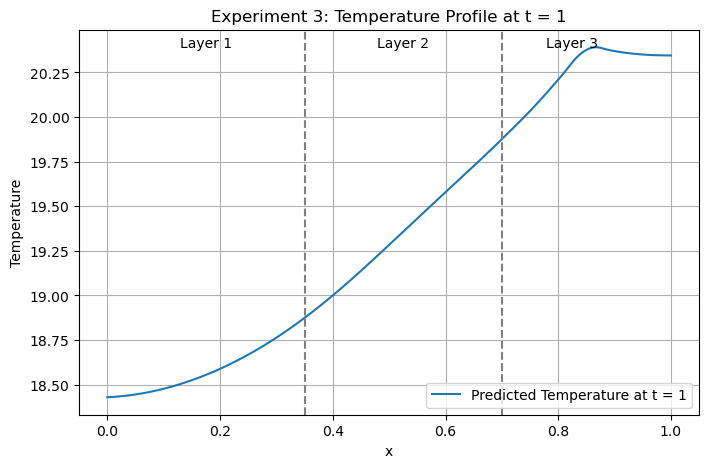

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(x_np, T_pred, label="Predicted Temperature at t = 1")
plt.axvline(x=0.35, color='gray', linestyle='--')
plt.axvline(x=0.7, color='gray', linestyle='--')
plt.text(0.175, T_pred.max(), 'Layer 1', ha='center')
plt.text(0.525, T_pred.max(), 'Layer 2', ha='center')
plt.text(0.825, T_pred.max(), 'Layer 3', ha='center')
plt.xlabel("x")
plt.ylabel("Temperature")
plt.title("Experiment 3: Temperature Profile at t = 1")
plt.legend()
plt.grid(True)
plt.show()

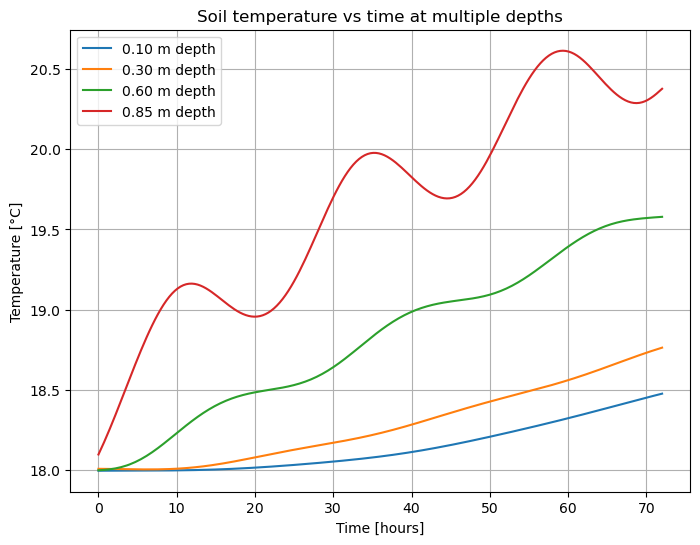

In [49]:
# --------------------------
# Generate prediction points
# --------------------------
model.eval()
with torch.no_grad():
    n_time = 200
    t_plot = torch.linspace(0,1,n_time).view(-1,1)
    depths = [0.1, 0.3, 0.6, 0.85]  # scaled depths
    T_results = []
    for d in depths:
        z_plot = torch.ones_like(t_plot) * d
        T_pred = model(z_plot, t_plot).cpu().numpy().flatten()
        T_results.append(T_pred)

# Convert time back to hours
t_hours = (t_plot.numpy().flatten() * 72)

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(8,6))
for i, d in enumerate([0.1,0.3,0.6,0.85]):
    plt.plot(t_hours, T_results[i], label=f"{d:.2f} m depth")
plt.xlabel("Time [hours]")
plt.ylabel("Temperature [°C]")
plt.title("Soil temperature vs time at multiple depths")
plt.legend()
plt.grid()
plt.show()


In [50]:
t_plot = torch.linspace(0, 1, 200).view(-1, 1)
x_plot = 0.85*torch.ones_like(t_plot)
T_pred = heat_source(x_plot, t_plot).detach().cpu().numpy()
t_np = t_plot.cpu().numpy()*72

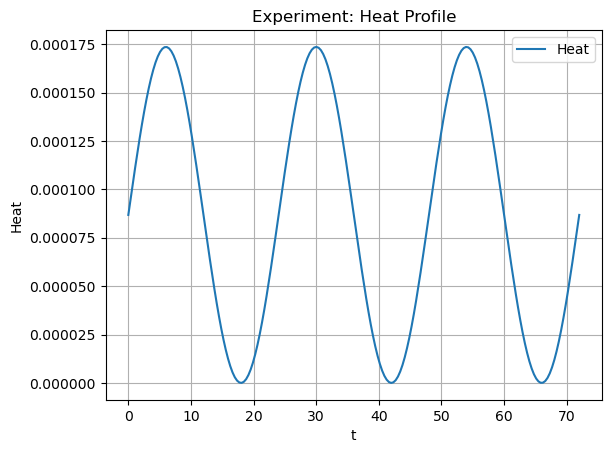

In [51]:
plt.plot(t_np, T_pred, label="Heat")
plt.xlabel("t")
plt.ylabel("Heat")
plt.title("Experiment: Heat Profile")
plt.legend()
plt.grid(True)
plt.show()